In [3]:
import copy
import hydra
import torch
from hydra import compose, initialize

import torchvision
import matplotlib.pyplot as plt
from utils import feature_visualisation

In [4]:
with initialize(version_base=None, config_path="../config"):
    cfg = compose(
        config_name="config",
        overrides=[],
    )

In [5]:
device = "cuda:0"
original_weights = cfg.model.get("original_weights_path", None)
if original_weights:
    original_weights = "{}/{}".format(cfg.model_dir, original_weights)
data_dir = cfg.data_dir
output_dir = cfg.output_dir
dataset = cfg.data
default_layer_str = cfg.model.layer
n_out = cfg.model.n_out
image_dims = cfg.data.image_dims
n_channels = cfg.data.n_channels
class_dict_file = cfg.data.get("class_dict_file", None)

fv_sd = float(cfg.fv_sd)
fv_dist = cfg.fv_dist
fv_domain = cfg.fv_domain
target_img_path = "./assets/adv_train/dalmatian.jpg"
batch_size = cfg.batch_size
train_original = cfg.train_original
replace_relu = cfg.replace_relu
alpha = cfg.alpha
w = cfg.w
img_str = cfg.img_str
gamma = cfg.gamma
lr = cfg.lr
man_batch_size = cfg.man_batch_size

In [6]:
image_transforms = hydra.utils.instantiate(dataset.fv_transforms)
normalize = hydra.utils.instantiate(cfg.data.normalize)
denormalize = hydra.utils.instantiate(cfg.data.denormalize)
resize_transforms = hydra.utils.instantiate(cfg.data.resize_transforms)

In [20]:
from core.manipulation_set import FrequencyManipulationSet, RGBManipulationSet

noise_dataset = (
    FrequencyManipulationSet(
        image_dims,
        "." + target_img_path,
        normalize,
        denormalize,
        image_transforms,
        resize_transforms,
        n_channels,
        fv_sd * 0.01,
        "normal",
        device,
    )
    if fv_domain == "freq"
    else RGBManipulationSet(
        image_dims,
        "." + target_img_path,
        normalize,
        denormalize,
        image_transforms,
        resize_transforms,
        n_channels,
        fv_sd * 0.01,
        "normal",
        device,
    )
)

In [8]:
model = hydra.utils.instantiate(cfg.model.model)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
target_neuron = int(cfg.model.target_neuron)
f = noise_dataset.forward

In [22]:
noise_dataset.param = noise_dataset.parametrize(
    noise_dataset.normalize(noise_dataset.target / 1.005 + 5e-8)
)
tstart = copy.deepcopy(noise_dataset.param)  # + noise_dataset.get_init_value()
image_transforms = torchvision.transforms.Compose(image_transforms)

In [23]:
# tstart = tstart.detach()
# rgb tensor, where red tensor is all 1's and the rest is 0s
rgb = torch.zeros_like(tstart)
rgb[:, 0, :, :] = 0.1
fwrd = copy.deepcopy(noise_dataset.target).requires_grad_().to(device)
# tf = v2.RandAugment()
# fwrd = tf(fwrd) #+ rgb #+ torch.rand_like(fwrd)*0.2
param = noise_dataset.parametrize(noise_dataset.normalize(fwrd / 1.005 + 5e-8))
param = noise_dataset.param.requires_grad_()
# param +=  torch.rand_like(param) * 0.04 - 0.02 * torch.ones_like(param)
y_t = model(f(param))[0]
print(
    torch.autograd.grad(y_t[target_neuron], param, create_graph=True)[0]
    .abs()
    .pow(2)
    .mean()
)

tensor(0.00420421, device='cuda:0', grad_fn=<MeanBackward0>)


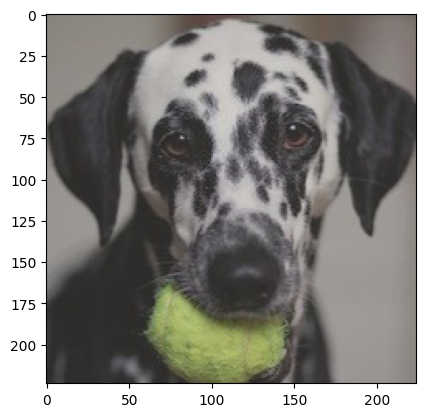

In [24]:
# fwrd = noise_dataset.to_image(tstart/1.1)
plt.imshow(noise_dataset.to_image(param)[0].permute(1, 2, 0).detach().cpu().numpy())

In [41]:
original = copy.deepcopy(noise_dataset.param)
tstart = copy.deepcopy(noise_dataset.param)  # + noise_dataset.get_init_value()
tstart = tstart.to(device).requires_grad_()
target = noise_dataset.target.to(device)
optimizer_fv = torch.optim.Adam([tstart], lr=0.01)
torch.set_printoptions(precision=8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fv, step_size=1000, gamma=0.5)
loss = 10000
n = 0
while 1:
    optimizer_fv.zero_grad()

    y_t = model(f(tstart))[0]
    grd = torch.autograd.grad(y_t[target_neuron], tstart, create_graph=True)
    loss = -y_t[target_neuron] + grd[0].pow(2).mean()
    print(loss)
    if loss < -10.0:
        break
    # loss = grd[0].abs().max().pow(2)
    if n % 100 == 0:
        print(loss)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_([tstart], grad_clip)
    optimizer_fv.step()
    if n  < 3000:
        scheduler.step()
    n += 1

print(grd[0].abs().pow(2).mean())
print(grd[0].abs().max().pow(2))

tensor(0.31293076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.31293076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.15594311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.07040425, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.38244775, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.52020478, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.72676849, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.93937284, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.12766361, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.26493561, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.38777232, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.53756130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.61685801, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.72311962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.75706363, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.82980764, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.89482427, device=

KeyboardInterrupt: 

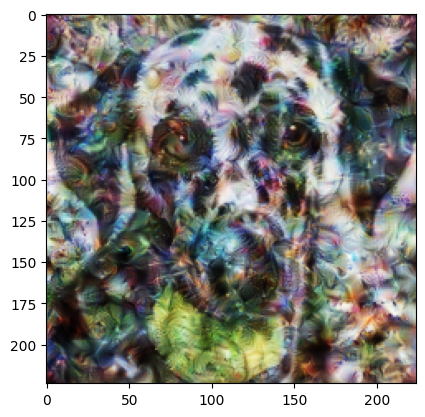

In [42]:
fwrd = noise_dataset.to_image(tstart)
plt.imshow(fwrd[0].permute(1, 2, 0).detach().cpu().numpy())

In [43]:
torchvision.utils.save_image(fwrd, "../assets/adv_train/dalmatian_tv_opt.jpg")